In [ ]:
import pandas as pd
import fasttext
import fasttext.util
import re
from sklearn.model_selection import train_test_split

data = pd.read_csv('./oscar_educational_scores_responses.csv')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\W+', ' ', text)
    text = text.strip()
    return text

data['text'] = data['text'].apply(preprocess_text)

data['fasttext_format'] = '__label__' + data['Educational score'].astype(str) + ' ' + data['text']

train_data, test_data = train_test_split(data['fasttext_format'], test_size=0.2, random_state=42)

train_file = 'train.txt'
test_file = 'test.txt'

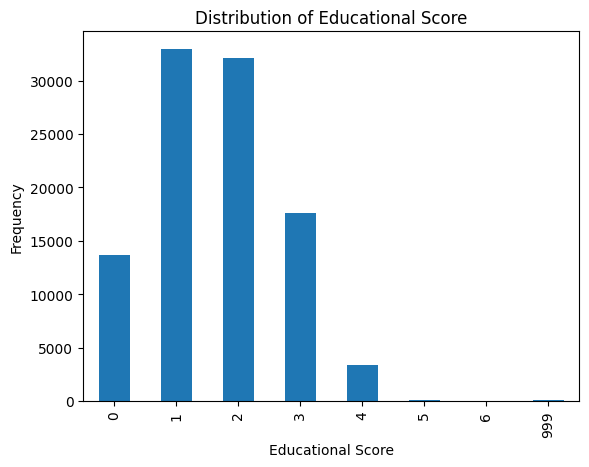

In [13]:
import matplotlib.pyplot as plt
data['Educational score'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Educational Score')
plt.xlabel('Educational Score')
plt.ylabel('Frequency')
plt.show()

In [3]:
with open(train_file, 'w', encoding="utf-8") as f:
    f.write('\n'.join(train_data))

with open(test_file, 'w', encoding="utf-8") as f:
    f.write('\n'.join(test_data))

In [16]:

model = fasttext.train_supervised(input=train_file, epoch=25, lr=0.5, wordNgrams=2, verbose=2, minCount=1)

In [17]:
model.test(test_file)

(20000, 0.51825, 0.51825)

In [23]:
model.save_model("./classifier.bin")

In [24]:
model.predict("Els Camins de la Música: Un monument de la música (i del Jazz) el Kind of Blue de Miles Davis Un monument de la música (i del Jazz) el Kind of Blue de Miles Davis 1959 va ser l'any en què determinats crítics musical varen sentenciar: El jazz està mort. Sota aqueixa làpida ontològica de proporcions nietszcheanes l'avantguarda jazzística nord-americana s'alliberava per a ser. En tota l'expressió. Ser música, més enllà del seu fonament, de la tradició. Mai com llavors es va registrar una efervescència creativa tan diversa i transcendent en els anals del jazz. Una efervescència concreta: cinc dels àlbums que van ser gravats o ben llançats en aqueix any van xifrar les rutes de subgèneres tan heterogenis com el free jazz, el jazz modal o el third stream (tercer corrent)...i el rock i la música d'avantguarda, la música electrònica i... Aquests discs varen ser: - The Shape of Jazz to come, Ornette Coleman - Time out, The Dave Brubeck Quartet - Mingus Ah Um, Charles Mingus Hui li toca al Kind of Blue. És un àlbum d'estudi de Miles Davis, publicat el 17 d'agost de 1959 a Columbia Records. Les sessions d'enregistrament d'aquest àlbum van tenir lloc als Columbia 30th Street Studio, a la ciutat de Nova York el 2 de març i el 22 d'abril de 1959. En aquestes sessions és presentava el sextet liderat per Miles Davis, amb el pianista Bill Evans, el bateria Jimmy Cobb, el baxista Paul Chambers i els saxofonistes John Coltrane i Cannonball Adderley. La producció va anar a càrrec del mag Teo Macero i Irving Townsend. Després de la inclusió de Bill Evans en el seu sextet,un music blanc en un grup de negres, cosa que li va molestar prou a John Coltrane, Davis va seguir experimentant el jazz modal tal com ja havia començat a fer a Milestones. Bill Evans va presentar a Miles a compositors clàssics, com Bela Bartok i Maurice Ravel, els qui utilitzaven harmonies modals en les seues composicions. Davis també es va basar en el seu coneixement de les qualitats modals en el blues. L'àlbum és basa totalment en l'estil modal en contrast amb els seus treballs anteriors en l'estil Hard Bop i els seves complexes progressións d'acords i improvisacions. Malgrat certes diferències en els xifres, Kind of Blue ha estat citat per molts crítics com l'àlbum més venut de Miles Davis, i també com l'enregistrament de jazz més venut de tots els temps. El 7 d'octubre de 2008, l'àlbum va ser certificat com a quàdruple platí en vendes per la Recording Industry Association of America (RIAA). També ha estat considerat per molts crítics com el millor àlbum de jazz de tots els temps i l'obra mestra de Davis, i ha estat classificat en els primers llocs dels llistes de millor àlbum de gèneres dispars. La influència de l'àlbum en la música, incloent-hi el jazz, el rock i la música clàssica, ha portat els escriptors de música a reconèixer-ho com un dels àlbums més influents de tot el temps. El 2002, va ser un dels cinquanta enregistraments escollits aquell any per la Biblioteca de Congrés dels EUA per ser afegit al Registre Nacional d'Enregistraments. És un àlbum que no es pot escoltar una sola vegada, cal fer-ho vàries vegades per descobrir tota la seua riquesa, les harmonies de Evans, les meravelloses improvisacions de Coltrane i Adderley i, per suposat, les màgiques intervencions de Miles Davis, junt amb la ma mestra del productor Teo Macero. Un clàssic entre els clàssics de qualsevol classe de música. Una obra mestra definitiva i una peça que va influenciar, influència i influenciarà tota la història de la música. De qualsevol tipus de música. Una obra cabdal. Etiquetes de comentaris: Bela Bartok, Bill Evans, Cannonball Adderley, John Coltrane, Kind of Blue, Miles Davis, Programes, Teo Macero", k=1)

(('__label__2',), array([0.50484705]))

In [27]:
from datasets import load_dataset
from tqdm import tqdm

In [28]:
dataset = load_dataset("uonlp/CulturaX", "ca", split="train", streaming=True)

def process_chunk(chunk):
    processed_texts = chunk['text'].apply(preprocess_text)
    predicted_labels = processed_texts.apply(lambda x: int(model.predict(x)[0][0].replace('__label__', '')))
    
    chunk['predicted_label'] = predicted_labels
    filtered_chunk = chunk[chunk['predicted_label'].isin([3, 4, 5])]
    
    return chunk, filtered_chunk

chunk_size = 100000
total_size = 15531777

with tqdm(total=total_size, desc="Processing dataset") as pbar:
    chunk = []
    for i, entry in enumerate(dataset):
        chunk.append(entry)
        
        if len(chunk) == chunk_size:
            chunk_df = pd.DataFrame(chunk)
            chunk, filtered_chunk = process_chunk(chunk_df)
            
            filtered_chunk.to_csv('culturaX_filtered.csv', mode='a', header=not i, index=False, columns=list(chunk.columns) + ['predicted_label'])
            chunk.to_csv('culturaX_tagged.csv', mode='a', header=not i, index=False, columns=list(chunk.columns) + ['predicted_label'])
            
            pbar.update(len(chunk))
            
            chunk = []
    
    if chunk:
        chunk_df = pd.DataFrame(chunk)
        chunk, filtered_chunk = process_chunk(chunk_df)
        
        filtered_chunk.to_csv('culturaX_filtered.csv', mode='a', header=not i, index=False, columns=list(chunk.columns) + ['predicted_label'])
        
        chunk.to_csv('culturaX_tagged.csv', mode='a', header=not i, index=False, columns=list(chunk.columns) + ['predicted_label'])
        
        pbar.update(len(chunk))
print("Processing complete. Filtered results saved to 'culturaX_filtered.csv'.")